# Transfer Learning ( 遷移學習 ) Example: dag&cat
### Goal: 利用CNN模型VGG16，和自行搭建MLP，辨識貓與狗
- 共25000筆訓練資料 (train)，無特別分出測試資料 (test) -> 與真實資料樣貌較相近

## Step1: Prepare Data
> ### 為何不Load Data?
> 本例圖檔太大又太多筆，直接load，RAM會爆掉
> 採取方法: 先列出圖片路徑；真的要訓練時再讀

In [ ]:
import zipfile
# 將zip檔解壓縮
zfile = zipfile.ZipFile("../dataset/dog_cat.zip")
zfile.extractall("../dataset/dog_cat")

In [1]:
import glob
import pandas as pd
# glob.glob() -> 回傳一個符合參數路徑的路徑list
# train筆數: len(glob.glob("dataset/train/*"))

catfn = glob.glob("../dataset/dog_cat/train/cat.*")
# 創出符合貓圖筆數的答案欄 (0: 代表cat)
catans = [0] * len(catfn)

dogfn = glob.glob("../dataset/dog_cat/train/dog.*")
# 創出符合狗圖筆數的答案欄 (0: 代表dog)
dogans = [1] * len(dogfn)

df = pd.DataFrame({
    "path": catfn + dogfn, 
    "target": catans + dogans
})
df

,path,target
0,../dataset/dog_cat/train\cat.0.jpg,0
1,../dataset/dog_cat/train\cat.1.jpg,0
2,../dataset/dog_cat/train\cat.10.jpg,0
3,../dataset/dog_cat/train\cat.100.jpg,0
4,../dataset/dog_cat/train\cat.1000.jpg,0
...,...,...
24995,../dataset/dog_cat/train\dog.9995.jpg,1
24996,../dataset/dog_cat/train\dog.9996.jpg,1
24997,../dataset/dog_cat/train\dog.9997.jpg,1
24998,../dataset/dog_cat/train\dog.9998.jpg,1


../dataset/dog_cat/train\cat.10896.jpg
(500, 369)


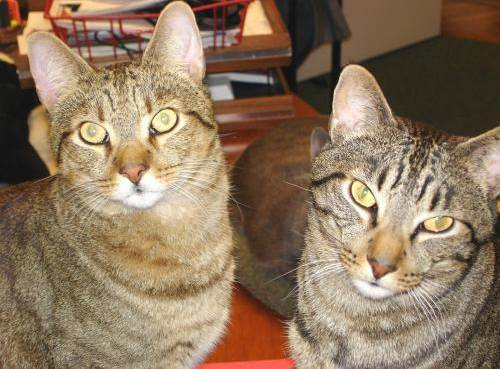

In [2]:
# 隨機選一張圖觀察
from tensorflow.keras.preprocessing.image import load_img
import random
c = random.randint(0, 24999)
print(df["path"][c])
img = load_img(df["path"][c])
print(img.size)
img
# 圖片大小為 (500, 369)

(224, 224)


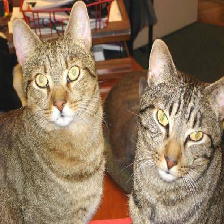

In [3]:
img = load_img(df["path"][c], target_size=(224, 224))
print(img.size)
img
# 即使縮小成(224, 224)(step2的處理)，也不會失真太嚴重

## Step2-1: 使用已訓練好的CNN模型 - VGG16
tensorflow.keras.applications下有許多知名模型

VGG16(include_top=, input_shape=)
- #### include_top: 選擇是否連同MLP一起使用                   
  因為當初訓練VGG16模型時，是與MLP一起訓練的；遷移學習欲自行搭建MLP，因此設定include_top=False
- #### input_shape: 圖片的大小；建議設定與當初訓練VGG16模型時相仿的圖片大小                  
  VGG16是用(224, 224, 3)，因此本例也選擇相同大小
  
  *在做圖片處理時，一定會對圖片做縮小；最後可再復原

> ### 為何選擇VGG16?
> 因為VGG16是Imagenet訓練、與本例相關的動物主題

In [4]:
from tensorflow.keras.applications.vgg16 import VGG16
cnn = VGG16(include_top=False, input_shape=(224, 224, 3))

cnn.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

## Step2-2: 建立神經網路模型
- ### Goal1: 固定CNN參數 (不再訓練CNN)
  走過CNN每一層，將trainable設定為False (印出summary觀察Trainable params與Non-trainable params)                         
  (!) trainable設定一定要在compile之前
  
- ### Goal2: 對CNN的output做BatchNormalization

> ### 為何要對CNN的output做Normalization?
> 因為在進入MLP前，VGG16使用的框架為caffe，輸出值約在-12x ~ 12x間；而進入MLP後，我們使用的是tensorflow框架，它預期的輸入值在-1~1之間；因此需先對CNN的output做Normalization，進入MLP訓練才不會有問題                        
  
- ### Goal3: 使用Model，在CNN上堆疊MLP Layers

![圖: Model](https://i.imgur.com/UNhyUxe.jpg)
  1.  一層一層function建立一個flow: 上一層的output = 下一層的input     
   
   function創建方式 -> 利用之前的layer，ex.Drop(0.25)、Dense()等
   
  2. #### Model(inputs=[ ], outputs=[ ]): 輸入input、output，建立神經網路模型
  inputs和outputs的list內必須放入tensor

(註) 建立模型仍然可用前兩例的方法: Sequential() + Dense

> ### 使用Model建立神經網路的優點?
> 一次可傳入兩個以上的tensor當作input、output


In [5]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import BatchNormalization

# (Goal1) 對CNN每一層做固定參數的動作
for l in cnn.layers:
    l.trainable = False

# (Goal2)
x = BatchNormalization()(cnn.output)

# (Goal3)
x = Flatten()(x)
x = Dense(64, activation="relu")(x)
x = Dropout(0.25)(x)
out = Dense(2, activation="softmax")(x)
# 使用softmax，有新增的彈性
# 也可以使用sigmoid，因為是二元(貓、狗)

model = Model(inputs=cnn.input, outputs=out)
model.summary()


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

### Param
- Total params: 所有Params相加                     
- Trainable params: MLP的Params + Batch Normalization 步驟2 Params
- Non-trainable params: 剛剛對CNN做參數固定的Params + Batch Normalization 步驟1 Params

### ( 註 ) Batch Normalization
![圖: Batch Normalization](https://i.imgur.com/6DXkD5C.jpg)

## Step2-3: 確定模型的訓練方式

In [6]:
from tensorflow.keras.losses import SparseCategoricalCrossentropy
model.compile(loss=SparseCategoricalCrossentropy(),
              optimizer="adam",
              metrics=["accuracy"])

## Step3-1: Data Preprocessing - 將資料分為訓練集與測試集
> ### 為何要將資料用numpy轉為array?
> 如果不轉，train_test_split時分開的欄位不會消失，而會變成空值NaN

In [7]:
import numpy as np
from sklearn.model_selection import train_test_split
# 將資料轉為 numpy array
x, y = np.array(df["path"]), np.array(df["target"])
# 將資料分為訓練集與測試集
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1)

## Step3-2: Data Preprocessing - 定義一個圖片預處理函數
> ### 為何要使用preprocess_input處理圖片資料?
> 因為vgg16模型當初不是用tensorflow，而是用caffe訓練的；因此我們不能自行處理資料，要用vgg16的preprocess_input處理

In [8]:
from tensorflow.keras.applications.vgg16 import preprocess_input
# BATCH: 幾筆做一次調整

def dataflow(x, y, BATCH=20):
    idx = np.random.randint(0, x.shape[0], size=BATCH)
    img_raw, img_process = [], []
    for p in x[idx]:
        img = load_img(p, target_size=(224, 224))
        img_np = np.array(img)
        img_raw.append(img_np)
        img_pre = preprocess_input(img_np)
        img_process.append(img_pre)
    return (np.array(img_raw),
            np.array(img_process),
            np.array(y[idx]))
# return value:(原圖, 預處理過的圖, 答案)

data = dataflow(x_train, y_train)
print(data[0].shape, data[1].shape, data[2].shape)

(20, 224, 224, 3) (20, 224, 224, 3) (20,)


## Step4: 訓練模型
> ### 為何要用train_on_batch、test_on_batch自行創建訓練函式，而不直接用fit?
> 資料太龐大，全載入再fit會跑不動；而train_on_batch、test_on_batch可在每次需要時才載入部分資料                     
> 另法: 使用fit_generator

In [13]:
# 用train_on_batch、test_on_batch自行創建訓練函式
for i in range(10):
    print("-" * 15,"第", i,"次訓練" ,"-" * 15)
    raw, img, ans = dataflow(x_train, y_train)
    train_result = model.train_on_batch(img, ans)
    print("Train:", train_result)

    raw, img, ans = dataflow(x_test, y_test)
    test_result = model.test_on_batch(img, ans)
    print("Validate:", test_result)

--------------- 第 0 次訓練 ---------------
Train: [0.0024916518, 0.8729508]
Validate: [6.7310686, 0.8]
--------------- 第 1 次訓練 ---------------
Train: [0.054270588, 0.95]
Validate: [4.5744424, 0.7]
--------------- 第 2 次訓練 ---------------
Train: [0.95143545, 0.9]
Validate: [1.8623962, 0.9]
--------------- 第 3 次訓練 ---------------
Train: [0.17323725, 0.95]
Validate: [7.715712, 0.8]
--------------- 第 4 次訓練 ---------------
Train: [0.3799838, 0.95]
Validate: [3.5340245, 0.8]
--------------- 第 5 次訓練 ---------------
Train: [0.6342804, 0.85]
Validate: [3.1335068, 0.8]
--------------- 第 6 次訓練 ---------------
Train: [0.5600394, 0.85]
Validate: [0.1061329, 0.95]
--------------- 第 7 次訓練 ---------------
Train: [0.7208183, 0.95]
Validate: [4.9734035, 0.85]
--------------- 第 8 次訓練 ---------------
Train: [0.38881123, 0.95]
Validate: [8.512968, 0.7]
--------------- 第 9 次訓練 ---------------
Train: [0.03471886, 1.0]
Validate: [6.675698e-07, 1.0]


### 觀察Validate loss:
- #### 上下跳動太大 -> 檢查是否沒有做Batch Normalize
- #### loss仍高但趨勢穩定 -> 可能是參數 ( 神經元數 ) 需做調整

In [14]:
model.predict(img)

array([[0.0000000e+00, 1.0000000e+00],
       [0.0000000e+00, 1.0000000e+00],
       [9.9999344e-01, 6.5426393e-06],
       [1.0000000e+00, 9.7365109e-11],
       [0.0000000e+00, 1.0000000e+00],
       [0.0000000e+00, 1.0000000e+00],
       [1.0000000e+00, 2.4662726e-19],
       [4.4769798e-27, 1.0000000e+00],
       [9.9999321e-01, 6.7909768e-06],
       [1.8888223e-27, 1.0000000e+00],
       [5.0813814e-16, 1.0000000e+00],
       [5.7009212e-29, 1.0000000e+00],
       [0.0000000e+00, 1.0000000e+00],
       [1.0000000e+00, 1.8068592e-09],
       [0.0000000e+00, 1.0000000e+00],
       [0.0000000e+00, 1.0000000e+00],
       [1.0000000e+00, 1.1224047e-10],
       [0.0000000e+00, 1.0000000e+00],
       [1.0000000e+00, 3.3119578e-09],
       [1.0000000e+00, 1.1046005e-22]], dtype=float32)

### 觀察預測機率值:
- #### 正常機率: [很小很小, 很大很大]
- #### 不正常機率: [1, 0]

In [15]:
raw, img, ans = dataflow(x_test, y_test, 200)
model.evaluate(img, ans)

200/200 [==============================] - 80s 398ms/sample - loss: 4.4762 - accuracy: 0.8500


[4.476192932203412, 0.85]

## Step5-1: Predict & Evaluate

In [16]:
# Model(非Sequential): 沒有predict_classes
# argmax: 找到最大值的索引
pre = model.predict(img).argmax(axis=1)
pre

array([1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0,
       1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1,
       1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0,
       0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1,
       1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0,
       0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1,
       0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1,
       0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1,
       1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1,
       1, 0], dtype=int64)

## Step5-2: 印出所有預測錯誤的圖及其他資訊

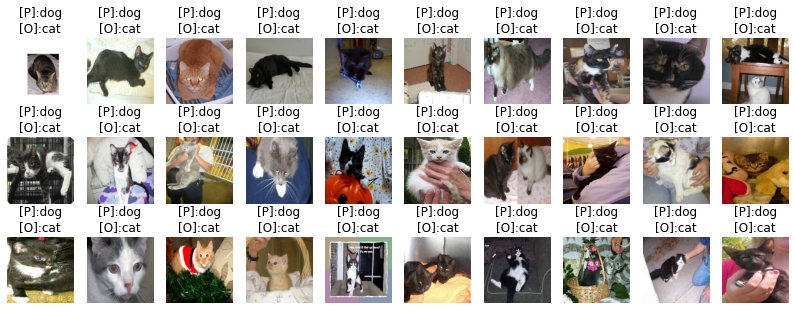

In [19]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
names = ["cat", "dog"]
idx = np.nonzero(pre != ans)[0]
false_pre_img = raw[idx]
false_pre_label = ans[idx]
false_pre_predict = pre[idx]

width = 10
height = len(idx) // width + 1
plt.figure(figsize=(14, 7))
for i, img in enumerate(false_pre_img):
    plt.subplot(height, width, i+1)
    t = "[P]:{}\n[O]:{}".format(names[false_pre_predict[i]],
                                names[false_pre_label[i]])
    plt.title(t)
    plt.axis("off")
    plt.imshow(img)